In [37]:
import numpy as np
import random
import pandas as pd 
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

import math, time
import itertools
import datetime
from operator import itemgetter
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
import torch.nn as nn
from torch.autograd import Variable
from skorch.callbacks import EarlyStopping
import torch.optim as optim
from skorch import NeuralNetRegressor

import optuna

/var/folders/3r/1_4kntk961qgw8h34vb14_8h0000gn/T/ipykernel_24490/2854789959.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [27]:
df = pd.read_excel('tsla_1min.xlsx', usecols=['Local Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df.rename(columns={'Local Date': 'Date'}, inplace=True)
df.sort_values('Date', inplace=True)
df.fillna(method='ffill', inplace=True)
df.head(5)

,Date,Close,Open,Low,High,Volume
43199,2022-05-11 10:01:00,812.84,813.04,803.04,814.00,3550.0
43198,2022-05-11 10:02:00,811.51,812.79,811.51,813.00,2877.0
43197,2022-05-11 10:03:00,812.60,811.89,810.36,812.60,3791.0
43196,2022-05-11 10:04:00,809.60,812.36,809.17,813.00,1491.0
43195,2022-05-11 10:05:00,808.90,808.88,808.33,809.71,654.0


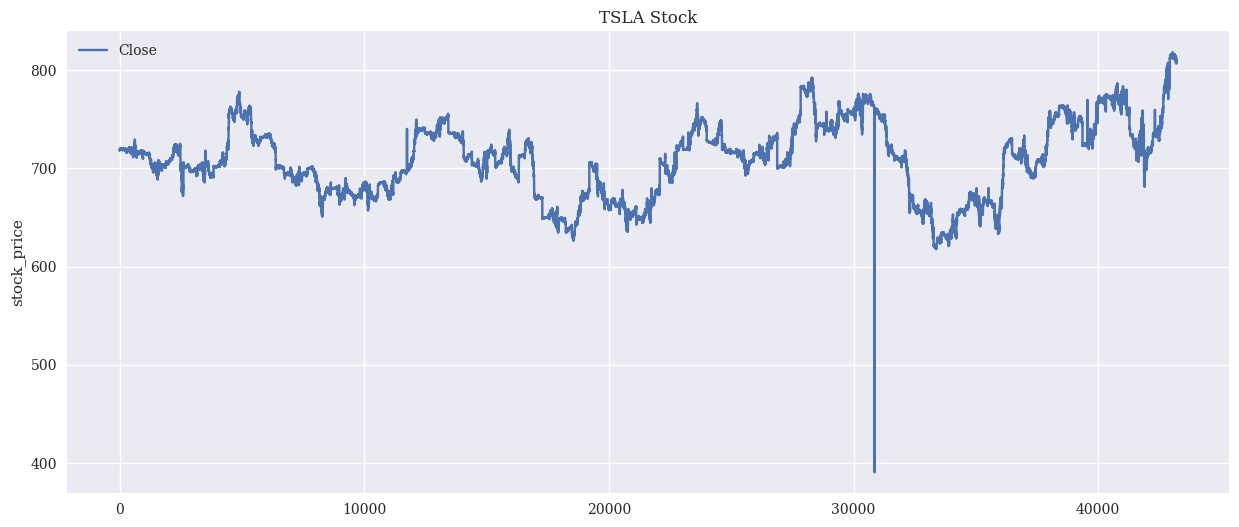

In [28]:
df[['Close']].plot(figsize=(15, 6))
plt.ylabel("stock_price")
plt.title("TSLA Stock")
plt.show()

In [29]:
X = df[['Open', 'Low', 'High', 'Volume']]
y = df['Close']

In [30]:
X.head(5)

,Open,Low,High,Volume
43199,813.04,803.04,814.00,3550.0
43198,812.79,811.51,813.00,2877.0
43197,811.89,810.36,812.60,3791.0
43196,812.36,809.17,813.00,1491.0
43195,808.88,808.33,809.71,654.0


In [106]:
# Splitting data into training and test sets initially
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# Define preprocessing for numeric and categorical columns
numeric_features = ['Open', 'Low', 'High', 'Volume']

numeric_transformer = StandardScaler()

# ColumnTransformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Applying transformations separately
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [107]:
X_train_transformed

array([[ 2.60726237,  2.37568637,  2.6049445 , -0.49665155],
       [ 2.60104582,  2.5859954 ,  2.58013379, -0.5078221 ],
       [ 2.57866622,  2.55744105,  2.57020951, -0.4926514 ],
       ...,
       [-0.71735122, -0.70421128, -0.73482479, -0.5283042 ],
       [-0.71884319, -0.70421128, -0.72961454, -0.52320857],
       [-0.71610791, -0.69527252, -0.72018647, -0.51695107]])

In [108]:
# Recreate DataFrames with feature names for interpretability
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=numeric_features, index=X_train.index)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=numeric_features, index=X_test.index)

In [109]:
X_train_transformed_df

,Open,Low,High,Volume
43199,2.607262,2.375686,2.604944,-0.496652
43198,2.601046,2.585995,2.580134,-0.507822
43197,2.578666,2.557441,2.570210,-0.492651
43196,2.590353,2.527893,2.580134,-0.530827
43195,2.503819,2.507036,2.498507,-0.544720
...,...,...,...,...
8644,-0.715859,-0.696514,-0.732096,-0.549317
8643,-0.714616,-0.697011,-0.732096,-0.551940
8642,-0.717351,-0.704211,-0.734825,-0.528304
8641,-0.718843,-0.704211,-0.729615,-0.523209


In [110]:
print('x_train.shape = ',X_train_transformed_df.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',X_test_transformed_df.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (34560, 4)
y_train.shape =  (34560,)
x_test.shape =  (8640, 4)
y_test.shape =  (8640,)


In [111]:
X_train_tensor = torch.tensor(X_train_transformed_df.values.astype(float)).float().unsqueeze(1)
X_test_tensor = torch.tensor(X_test_transformed_df.values.astype(float)).float().unsqueeze(1)

y_train_tensor = torch.tensor(y_train.values.astype(float)).float()
y_test_tensor = torch.tensor(y_test.values.astype(float)).float()

In [112]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        batch_size = x.size(0) # Extract batch size from input
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        out, (h0, c0) = self.lstm(x, (h0.detach(), c0.detach()))

        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :]) # Select the output of the last time step
        
        return out


In [130]:
net = NeuralNetRegressor(
    module=LSTM,
    module__input_size=X_train_transformed_df.shape[1],  # Number of features
    module__hidden_size=32,
    module__num_layers=2,
    module__output_size=1,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    optimizer__lr=0.001,
    batch_size=32,
    max_epochs=100,
    callbacks=[EarlyStopping(patience=5)],
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

net.fit(X_train_tensor, y_train_tensor)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   469857.0373   509218.5067  1.1281
      2   435607.0786   477457.6778  1.0326
      3   407064.6947   448028.4235  0.9890
      4   380198.2232   419986.1451  1.2816
      5   354541.2576   393065.0469  1.1473
      6   329932.3348   367156.9284  1.1269
      7   306301.2909   342211.8916  1.0981
      8   283614.9933   318206.4144  1.1528
      9   261857.0304   295128.0121  1.0082
     10   241018.6137   272970.2948  1.6748
     11   221094.5448   251729.0428  1.2720
     12   202081.2927   231401.8600  1.1062
     13   183975.5190   211985.1766  0.9834
     14   166774.2120   193476.9357  0.9767
     15   150474.4612   175874.3381  0.9734
     16   135073.0075   159175.1483  0.9871
     17   120566.6033   143375.7052  1.0421
     18   106950.7232   128472.8088  1.0995
     19    94221.4900   114463.2731  1.1709
     20    82373.7747   101342.5451  1.0262
     21    71402.0144    89105.8

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=LSTM(
    (lstm): LSTM(4, 32, num_layers=2, batch_first=True)
    (fc): Linear(in_features=32, out_features=1, bias=True)
  ),
)

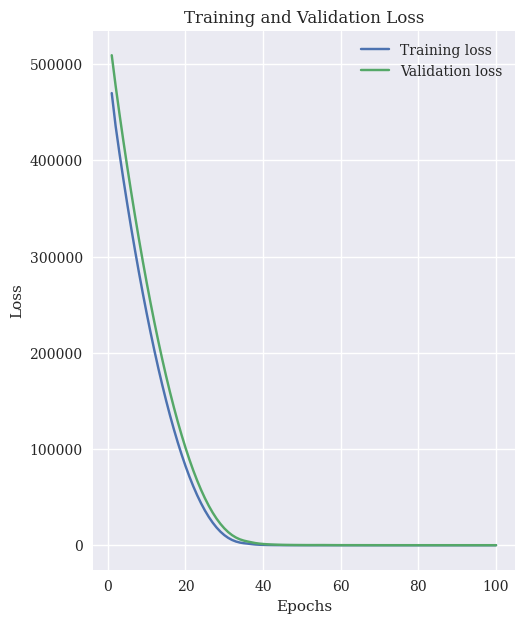

In [131]:
# Access training history
history = net.history_

# Extract training and validation loss
train_loss = history[:, 'train_loss']
valid_loss = history[:, 'valid_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 7))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, valid_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

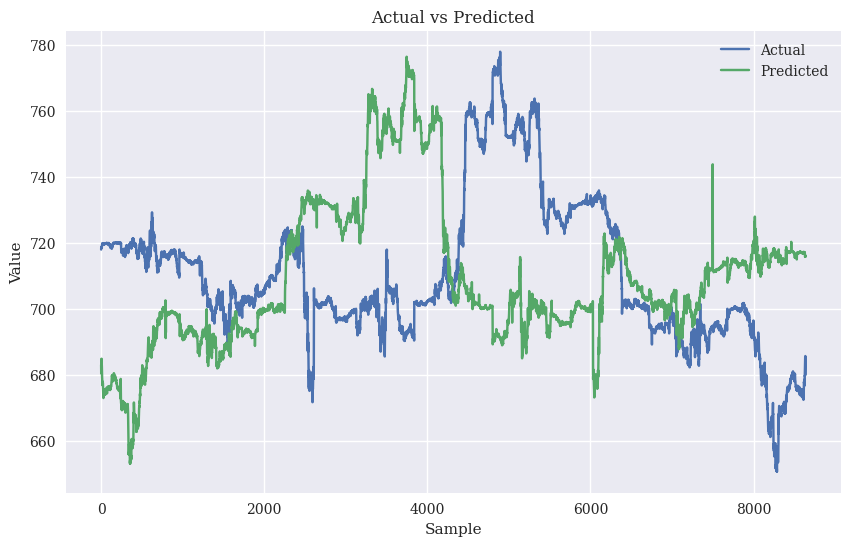

In [132]:
# Obtain predictions on the test set
y_pred = net.predict(X_test_tensor)

# Plot predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [133]:
# Predictions on the training set
y_train_pred = net.predict(X_train_tensor)

# Calculate mean squared error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate mean squared error (MSE) for test set
mse_test = mean_squared_error(y_test, y_pred)

print("Mean Squared Error (MSE) - Training Set:", mse_train)
print("Mean Squared Error (MSE) - Test Set:", mse_test)


Mean Squared Error (MSE) - Training Set: 16.807764333490407
Mean Squared Error (MSE) - Test Set: 3.0904439548730926


### Optuna - Hyperparameter tuning

In [136]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 16, 64)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    lr = trial.suggest_float('lr', 1e-5, 1e-2)
    
    # Construct the LSTM model with suggested hyperparameters
    class LSTM(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, output_size):
            super(LSTM, self).__init__()
            self.hidden_size = hidden_size
            self.num_layers = num_layers
            
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_size)
        
        def forward(self, x):
            batch_size = x.size(0)
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_()
            
            out, _ = self.lstm(x, (h0, c0))
            out, (h0, c0) = self.lstm(x, (h0.detach(), c0.detach()))
            
            out = self.fc(out[:, -1, :])
            
            return out
    
    # Construct the NeuralNetRegressor with suggested hyperparameters
    net = NeuralNetRegressor(
        module=LSTM,
        module__input_size=X_train_transformed_df.shape[1],
        module__hidden_size=hidden_size,
        module__num_layers=num_layers,
        module__output_size=1,
        criterion=nn.MSELoss,
        optimizer=optim.Adam,
        optimizer__lr=lr,
        batch_size=32,
        max_epochs=100,
        verbose=0,
        callbacks=[EarlyStopping(patience=5)],
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )
    
    # Train the model
    net.fit(X_train_tensor, y_train_tensor)
    
    # Return the validation loss for Optuna to minimize
    return net.history[-1]['valid_loss']


# Create an Optuna study
study = optuna.create_study(direction='minimize')

# Run Optuna optimization
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2024-03-27 00:22:52,951] A new study created in memory with name: no-name-5f084eb0-8422-468b-b399-4e31cfa1892a
[I 2024-03-27 00:24:16,744] Trial 0 finished with value: 2687.1705640399896 and parameters: {'hidden_size': 39, 'num_layers': 3, 'lr': 0.0008702973278901666}. Best is trial 0 with value: 2687.1705640399896.
[I 2024-03-27 00:25:31,688] Trial 1 finished with value: 50.20964061703395 and parameters: {'hidden_size': 44, 'num_layers': 1, 'lr': 0.00141898019941257}. Best is trial 1 with value: 50.20964061703395.
[I 2024-03-27 00:25:54,483] Trial 2 finished with value: 2811.544521974193 and parameters: {'hidden_size': 25, 'num_layers': 3, 'lr': 0.005534161805666689}. Best is trial 1 with value: 50.20964061703395.
[I 2024-03-27 00:26:49,188] Trial 3 finished with value: 83.8725574982387 and parameters: {'hidden_size': 61, 'num_layers': 2, 'lr': 0.008132483052413191}. Best is trial 1 with value: 50.20964061703395.
[I 2024-03-27 00:27:14,853] Trial 4 finished with value: 113.14018869

Best Hyperparameters: {'hidden_size': 44, 'num_layers': 1, 'lr': 0.00141898019941257}


In [139]:
print("Best trial:")
trial = study.best_trial

print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


Best trial:
  Params: 
    hidden_size: 44
    num_layers: 1
    lr: 0.00141898019941257


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   462826.2474   482326.9152  0.8689
      2   389937.9120   413359.2138  0.7502
      3   334955.4334   359543.0354  0.7297
      4   288455.6259   312322.1118  0.7322
      5   247129.2411   269718.9274  0.8279
      6   209871.3600   230974.5364  0.7818
      7   176207.1873   195740.9552  0.7316
      8   145902.3161   163838.1553  0.7819
      9   118823.6385   135158.5429  0.7313
     10    94879.8472   109624.6993  0.7327
     11    73993.8664    87167.7642  0.7297
     12    56086.7162    67715.8706  0.7359
     13    41068.3613    51186.7130  0.7666
     14    28828.9630    37479.9960  0.7294
     15    19227.7188    26467.2126  0.7346
     16    12079.8205    17981.4692  0.7341
     17     7137.3803    11801.3615  0.7278
     18     4068.0939     7631.2024  0.7358
     19     2440.4942     5090.7176  0.7287
     20     1752.2444     3729.9539  0.7299
     21     4136.8199     2855.0

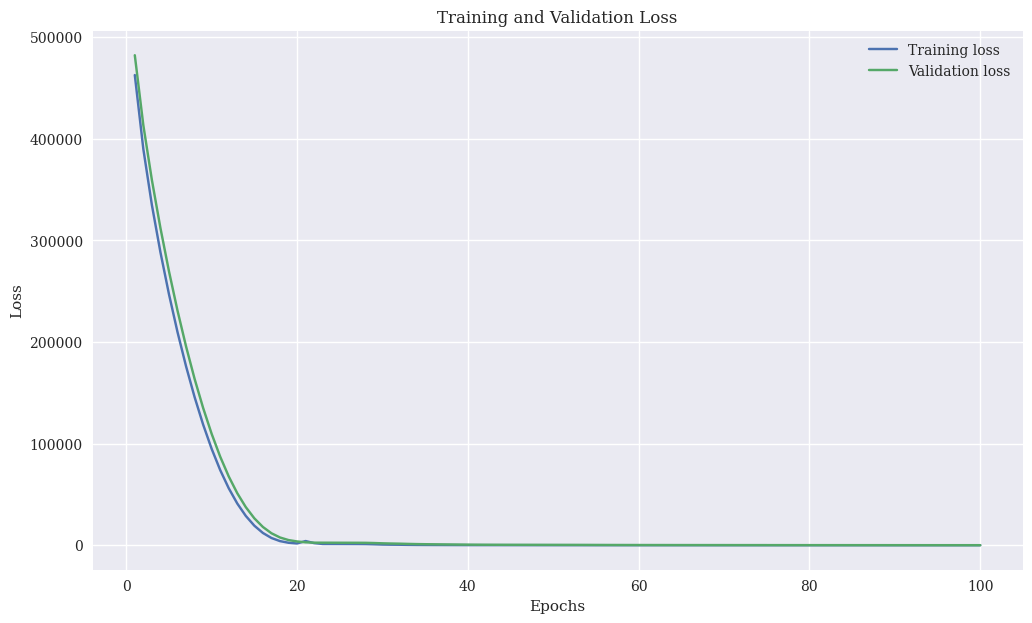

In [140]:
# Get the best hyperparameters
best_params = study.best_params

# Construct the LSTM model with the best hyperparameters
best_model = NeuralNetRegressor(
    module=LSTM,
    module__input_size=X_train_transformed_df.shape[1],
    module__hidden_size=best_params['hidden_size'],
    module__num_layers=best_params['num_layers'],
    module__output_size=1,
    criterion=nn.MSELoss,
    optimizer=optim.Adam,
    optimizer__lr=best_params['lr'],
    batch_size=32,
    max_epochs=150,
    callbacks=[EarlyStopping(patience=5)],
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Fit the best model with the entire training dataset
best_model.fit(X_train_tensor, y_train_tensor)

# Plot training and validation loss
history = best_model.history
train_loss = history[:, 'train_loss']
valid_loss = history[:, 'valid_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 7))

plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, valid_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


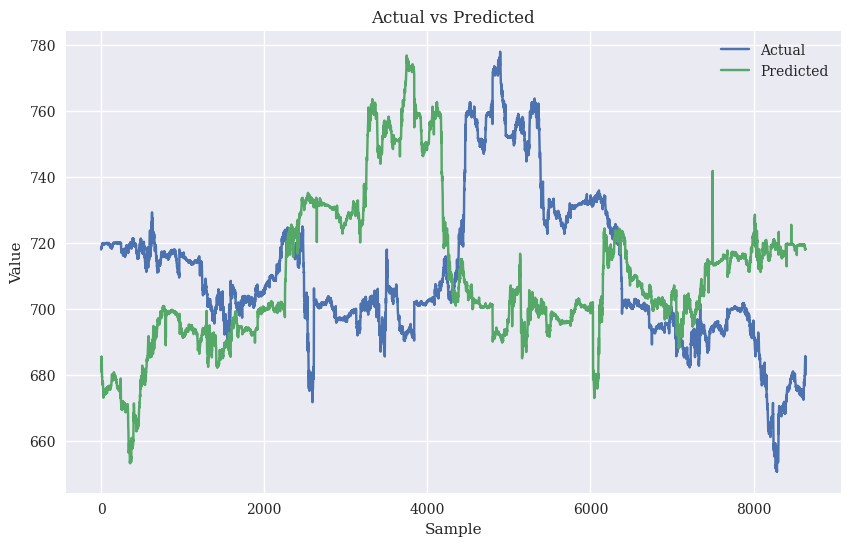

In [141]:
# Obtain predictions on the test set using the best model found by Optuna
y_pred = best_model.predict(X_test_tensor)

# Plot predictions against actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [142]:
# Predictions on the training set
y_train_pred = best_model.predict(X_train_tensor)

# Calculate mean squared error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate mean squared error (MSE) for test set
mse_test = mean_squared_error(y_test, y_pred)

print("Mean Squared Error (MSE) - Training Set:", mse_train)
print("Mean Squared Error (MSE) - Test Set:", mse_test)


Mean Squared Error (MSE) - Training Set: 14.893309670631623
Mean Squared Error (MSE) - Test Set: 1.240172764457253
